# Prediccion del indice S&P 500 mediante XGBOOST y el modelo GARCH

In [37]:
# base
import pandas as pd
import numpy as np
import math
import datetime
import datetime as dt
import statsmodels.api as sms


# importacion datos financieros
import yfinance as yf

#metricas de evaluacion 

from arch.unitroot import PhillipsPerron , KPSS , ADF
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

# Graficas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Prediccion modelos GARCH
from pmdarima import auto_arima
import arch
from arch import arch_model

# Prediccion modelo XGBOOST
import xgboost as xgb


# Lectura de datos

In [38]:
data = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4773040000


In [39]:
data = data.rename(columns=str.lower)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 597 entries, 2021-01-04 to 2023-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       597 non-null    float64
 1   high       597 non-null    float64
 2   low        597 non-null    float64
 3   close      597 non-null    float64
 4   adj close  597 non-null    float64
 5   volume     597 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 32.6 KB


In [40]:
data['time'] = data.index

In [41]:
retornos = data[['close']].pct_change().dropna() * 100
retornos.head()

,close
Date,
2021-01-05,0.708260
2021-01-06,0.570984
2021-01-07,1.484740
2021-01-08,0.549186
2021-01-11,-0.655475


In [42]:
# media rendimientos diarios
retornos.mean()

close    0.026634
dtype: float64

In [43]:
# grafica de los retornos
close_price = retornos
rendimiento_acum_dia = close_price/close_price.iloc[0,:]
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

In [44]:
# volatilidad diaria
daily_volatility = retornos.values.std()
daily_volatility

1.1867987576811718

In [45]:
monthly_volatility = math.sqrt(21)*daily_volatility # 21 porque hay 21 dias habiles en el mes
monthly_volatility

5.438595141753523

<AxesSubplot:title={'center':'Rtornos diarios'}, xlabel='Date'>

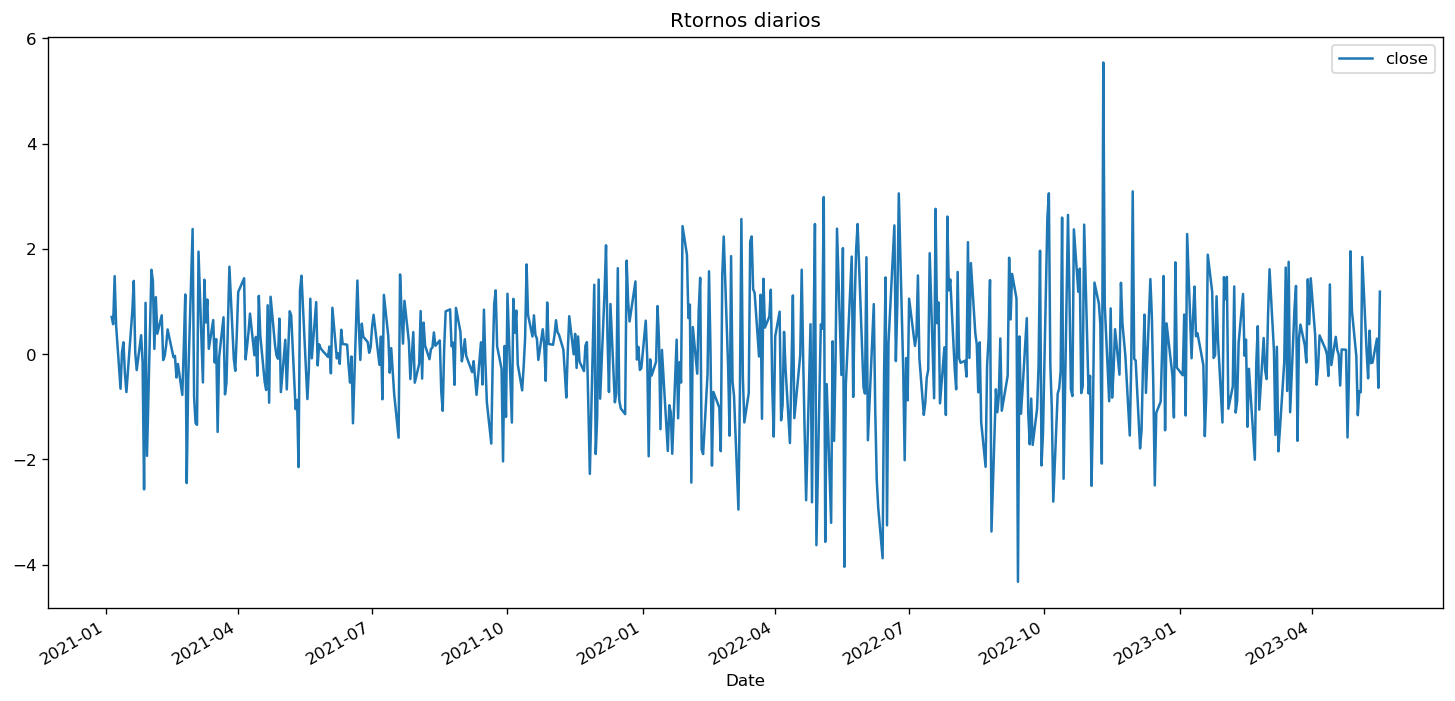

In [46]:
# retornos diarios sin acumulado
retornos.plot(figsize=(15,7),title='Rtornos diarios')

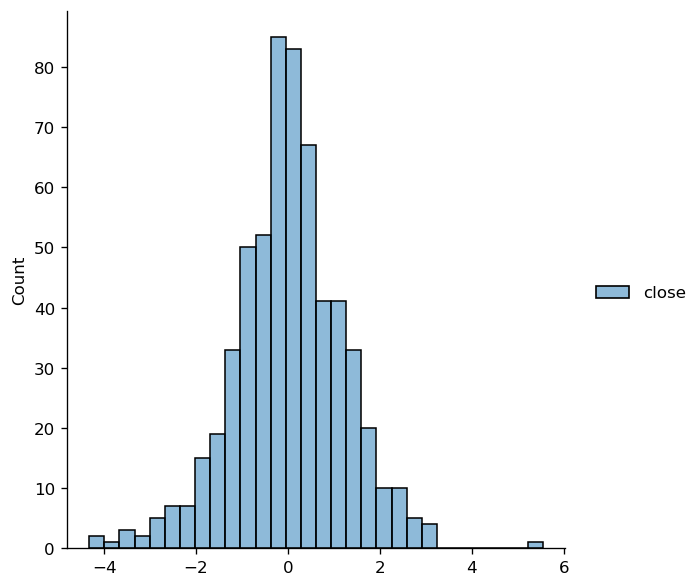

In [47]:
sns.displot(retornos)

# Modelo GARCH 

## Test de estacionariedad
* ADF :

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* PP:

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* KPSS :

$H_0$ = El proceso es debilmente estacionario

$H_1$ = El proceso contiene raiz unitaria

In [48]:
def Estacionariedad(data):
  """
  Realiza el test ADF, PP, KPSS sobre una serie de tiempo indicada en df 
  y una columna en especifico indicada en pais
  """
  adf_pvalue = round(ADF(data).pvalue, 6)
  pp_pvalue = round(PhillipsPerron(data).pvalue, 6)
  kpss_pvalue = round(KPSS(data).pvalue, 6)
  
  results = {'ADF': [adf_pvalue], 'PP': [pp_pvalue], 'KPSS': [kpss_pvalue]}
  df_tests = pd.DataFrame(results)
  
  return df_tests


In [49]:
Estacionariedad(retornos)

,ADF,PP,KPSS
0,0.0,0.0,0.43737


como p-valor < $\alpha$ se rechaza $H_o$ para el test ADF Y PP
y se acepta KPSS. No parece haber reiz unitaria en los retornos del activo

## Grafica ACF y PACF

c:\Users\Juan Guzman\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



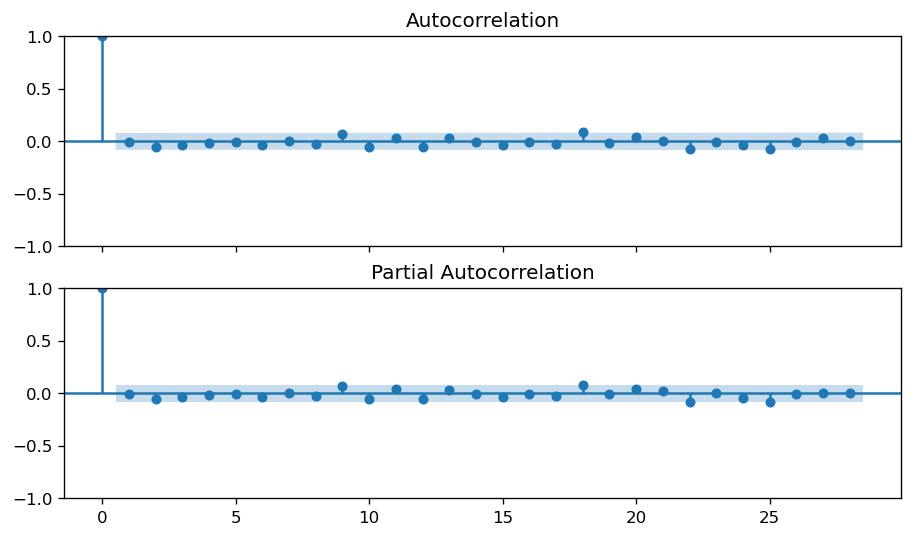

In [50]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=True)

plot_acf(retornos,ax=axes[0])
plot_pacf(retornos,ax=axes[1])
plt.show()

convergen rapidamente al intervalo

## estimacion modelo

In [51]:
import arch
from arch import arch_model

# Crear un modelo GARCH
model = arch_model(retornos,dist='ged', vol='Garch',p=4,q=4)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                              close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -894.002
Distribution:      Generalized Error Distribution   AIC:                           1810.00
Method:                        Maximum Likelihood   BIC:                           1858.30
                                                    No. Observations:                  596
Date:                            Wed, May 17 2023   Df Residuals:                      595
Time:                                    16:19:43   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0712  3.747e-02      1.901  5.728e-02 [-2.204e-03,  0.145]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0367  4.769e-02      0.770      0.442 [-5.677e-02,  0.130]
alpha[1]       0.0367  5.693e-02      0.644      0.519 [-7.490e-02,  0.148]
alpha[2]       0.1250  5.919e-02      2.112  3.472e-02  [8.976e-03,  0.241]
alpha[3]       0.0581      0.115      0.503      0.615    [ -0.168,  0.284]
alpha[4]   6.9448e-15  6.025e-02  1.153e-13      1.000    [ -0.118,  0.118]
beta[1]        0.0000      0.967      0.000      1.000    [ -1.894,  1.894]
beta[2]        0.0000      0.947      0.000      1.000    [ -1.855,  1.855]
beta[3]        0.3810      0.661      0.576      0.564    [ -0.915,  1.677]
beta[4]        0.3784      0.592      0.639      0.523    [ -0.782,  1.539]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5470      0.143     10.849  2.023e-27 [  1.267,  1.826]
========================================================================

Covariance estimator: robust
"""

realizar una media movil de 15 dias de los rendimientos

In [52]:
# definir la serie completa como el modelo previamente definido
full_serie_garch = arch_model(retornos,dist='ged',vol='GARCH',p=4,q=4)
# ajuste del modelo para la serie completa
model_fit_full_serie = full_serie_garch.fit(disp='off')

In [53]:
# conspiraremos contra la volatilidad rodante
# promedio movil de 15 dias de los rendimientos
rolling_vol = abs(retornos.rolling(window=15,min_periods=15).std().dropna())
rolling_vol

,close
Date,
2021-01-26,0.668991
2021-01-27,0.977675
2021-01-28,0.998550
2021-01-29,1.042418
2021-02-01,1.125609
...,...
2023-05-11,0.977655
2023-05-12,0.978227
2023-05-15,0.981210


In [54]:
# Concatenar los valores verdaderos y los entrenados por el modelo
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),rolling_vol.dropna()],axis=1).dropna()
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.787872,0.668991
2021-01-27,0.814518,0.977675
2021-01-28,0.933830,0.998550
2021-01-29,1.196368,1.042418
2021-02-01,1.085360,1.125609
...,...,...
2023-05-11,0.878676,0.977655
2023-05-12,0.913728,0.978227
2023-05-15,0.911648,0.981210


In [55]:
garch_and_rolling_std_plot = px.line(garch_and_rolling_std,
                                     title="GARCH vs rolling volatilidad de los retonros diarios")
garch_and_rolling_std_plot.show()

Usando un rango de 180 dias para pronosticar los valores, para cada dia estamos ajustando un nuveo modelo con los mismos parametros, pero agregando el ultimo dia


In [87]:
test_size = 90
rolling_predictions = [] #180 predicciones

for i in range(test_size):
    train = retornos[:-(test_size-i)]
    model = arch_model(train,dist="ged",vol='GARCH',p=4,q=4)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex=False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [57]:
rolling_predictions[:10] # primeros 10

[1.839215138737907,
 1.5950895072694056,
 1.2434019061610162,
 1.4149612322522431,
 1.383998993643723,
 1.1895477208276488,
 1.241174617909493,
 1.338974226915523,
 1.2865920149197794,
 1.189319213845712]

In [58]:
# guardar las pred en un DF
rolling_pred = pd.DataFrame(rolling_predictions,index=retornos.index[-test_size:])
rolling_pred = rolling_pred.rename(columns={0:'pred'})
rolling_pred

,pred
Date,
2022-08-30,1.839215
2022-08-31,1.595090
2022-09-01,1.243402
2022-09-02,1.414961
2022-09-06,1.383999
...,...
2023-05-11,0.880315
2023-05-12,0.915036
2023-05-15,0.912955


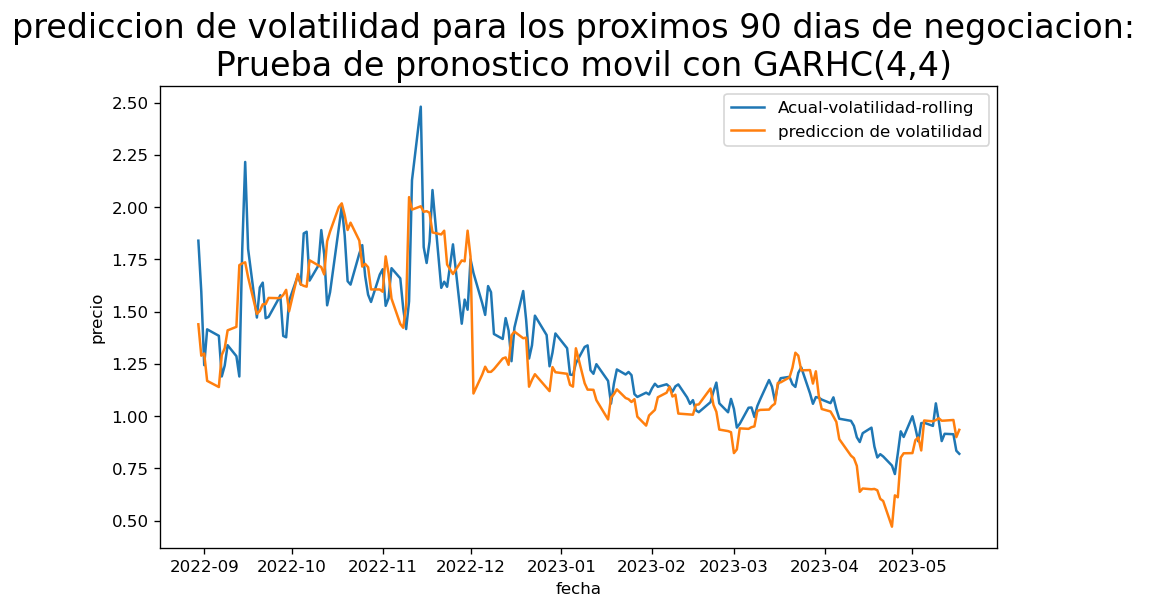

In [59]:
# graficar los datos reales y las predicciones de volatilidad
plt.plot(rolling_pred,label='Acual-volatilidad-rolling')
plt.plot((rolling_vol)[-test_size:],label='prediccion de volatilidad')
plt.title('prediccion de volatilidad para los proximos 90 dias de negociacion: \n Prueba de pronostico movil con GARHC(4,4)',fontsize=20)
plt.xlabel('fecha')
plt.ylabel('precio')
plt.legend()
plt.show()


# GXBOOST

In [60]:
df = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
df_ml = df[['Close']]
df_ml.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [61]:
# retornos
df_ml['retornos'] = 100 * df_ml['Close'].pct_change()
df_ml = df_ml.dropna()
df_ml.head()

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2464780598.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,retornos
Date,,
2021-01-05,3726.860107,0.708260
2021-01-06,3748.139893,0.570984
2021-01-07,3803.790039,1.484740
2021-01-08,3824.679932,0.549186
2021-01-11,3799.610107,-0.655475


In [62]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2021-01-05 to 2023-05-17
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     596 non-null    float64
 1   retornos  596 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


In [63]:
df_ml.describe()

,Close,retornos
count,596.000000,596.000000
mean,4164.197756,0.026634
std,284.384122,1.187796
min,3577.030029,-4.323661
25%,3934.717529,-0.667366
50%,4136.189941,0.016058
75%,4395.354858,0.739484
max,4796.560059,5.543448


In [64]:
# promedio movil de 22 dias
df_ml['win_22'] = abs(df_ml['retornos'].rolling(window=22,min_periods=22).std().dropna())
df_ml.head(16)

,Close,retornos,win_22
Date,,,
2021-01-05,3726.860107,0.708260,NaN
2021-01-06,3748.139893,0.570984,NaN
2021-01-07,3803.790039,1.484740,NaN
2021-01-08,3824.679932,0.549186,NaN
2021-01-11,3799.610107,-0.655475,NaN
2021-01-12,3801.189941,0.041579,NaN
2021-01-13,3809.840088,0.227564,NaN
2021-01-14,3795.540039,-0.375345,NaN
2021-01-15,3768.250000,-0.719003,NaN


In [65]:
df_ml.reset_index(inplace=True)

In [66]:
df_ml.info() #la fecha esta en tiempo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      596 non-null    datetime64[ns]
 1   Close     596 non-null    float64       
 2   retornos  596 non-null    float64       
 3   win_22    575 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 18.8 KB


In [67]:
# renombrar el df
serie_for_xgboost = df_ml
# establecer el tamaño del test
test_size = 90
# dividir el df en train y test
train_ml = serie_for_xgboost[:-(test_size)].dropna()
test_ml = serie_for_xgboost[-(test_size):].dropna()

In [68]:
train_ml.head()

,Date,Close,retornos,win_22
21,2021-02-04,3871.739990,1.085332,1.053701
22,2021-02-05,3886.830078,0.389750,1.048719
23,2021-02-08,3915.590088,0.739935,1.052205
24,2021-02-09,3911.229980,-0.111352,1.014038
25,2021-02-10,3909.879883,-0.034518,1.010222


In [69]:
train_ml.shape, test_ml.shape

((485, 4), (90, 4))

In [70]:
# extraer carac para series de tiempo
def create_features(df,label=None):
    '''
    Crear caracteristicas de fecha para el indice datetime
    '''
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day

    X = df[['dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X


In [71]:
X_train, y_train = create_features(train_ml, label="win_22")
X_test, y_test = create_features(test_ml, label="win_22")

In [72]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth
21,3,1,2,2021,35,4
22,4,1,2,2021,36,5
23,0,1,2,2021,39,8
24,1,1,2,2021,40,9
25,2,1,2,2021,41,10


In [73]:
# crear adicionalmente caracteristicas que usen los 4 dias previos de rolling volatility, incorporando el componente autorregresivo para nuesto modelo de ML
X_train['prev1'] = train_ml['win_22'].shift(1) # shift trae los rezagos
X_test['prev1'] = test_ml['win_22'].shift(1)
X_train['prev2'] = train_ml['win_22'].shift(2)
X_test['prev2'] = test_ml['win_22'].shift(2)
X_train['prev3'] = train_ml['win_22'].shift(3)
X_test['prev3'] = test_ml['win_22'].shift(3)

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2818475730.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2818475730.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2818475730.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [74]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,prev1,prev2,prev3
21,3,1,2,2021,35,4,NaN,NaN,NaN
22,4,1,2,2021,36,5,1.053701,NaN,NaN
23,0,1,2,2021,39,8,1.048719,1.053701,NaN
24,1,1,2,2021,40,9,1.052205,1.048719,1.053701
25,2,1,2,2021,41,10,1.014038,1.052205,1.048719
...,...,...,...,...,...,...,...,...,...
501,4,4,12,2022,364,30,1.313085,1.276689,1.260512
502,1,1,1,2023,3,3,1.313358,1.313085,1.276689
503,2,1,1,2023,4,4,1.098603,1.313358,1.313085
504,3,1,1,2023,5,5,1.120351,1.098603,1.313358


## implementacion modelo XGBOOST

In [75]:
reg = xgb.XGBRFRegressor(n_stimators = 1000)
# entrenamiento del modelo
reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train),(X_test,y_test)],
                    verbose=False)

[16:20:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_stimators" } are not used.



XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, n_stimators=1000,
               num_parallel_tree=None, objective='reg:squarederror',
               predictor=None, random_state=None, ...)

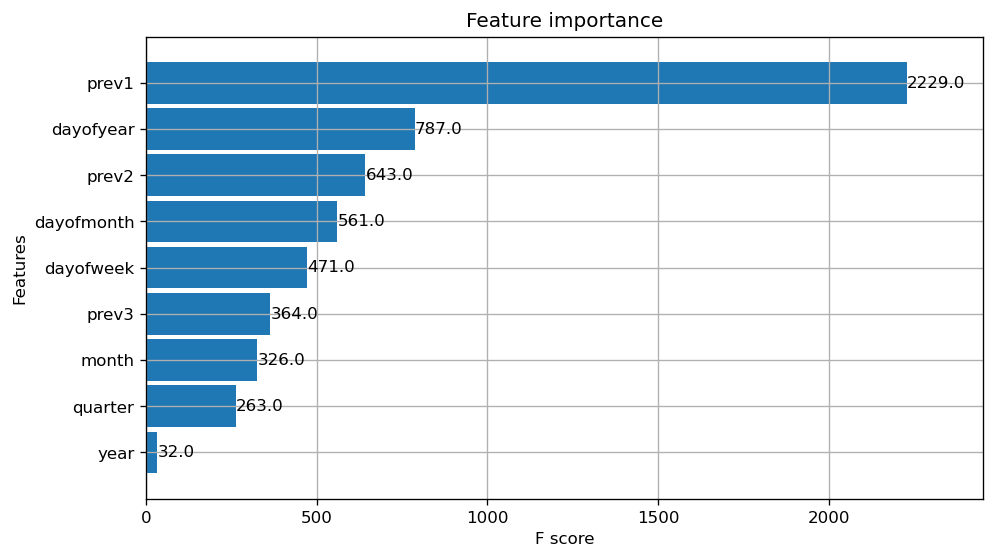

In [76]:
# visualizacion las variables de mas importancia en el modelo
__ = plot_importance(reg,height=0.9)

el primer rezago, dias del año y dias del mes las mas importantes

In [77]:
# realizamos las predicciones para train y test
train_ml['Predictions'] = reg.predict(X_train)
test_ml['Predictions'] = reg.predict(X_test)

In [78]:
# df con pred y real
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml['Predictions']),list(train_ml['win_22']))],axis=1).dropna().reset_index()
# renombramiento de columnas
XGBoost_and_rolling.rename(columns={'index':'Real_volatility',0:"Predicted Volatility"},inplace=True)
XGBoost_and_rolling.head()

,Real_volatility,Predicted Volatility
0,1.053701,1.210023
1,1.048719,1.050781
2,1.052205,1.039814
3,1.014038,1.037842
4,1.010222,1.032592


In [79]:
XGBoost_and_rolling.set_index(train_ml['Date'],inplace=True)

In [80]:
XGBoost_and_rolling = px.line(XGBoost_and_rolling,
                              title="XGBOOST vs rolling volatilidad de los retornos para train")
XGBoost_and_rolling.show()

In [81]:
test_ml.set_index('Date',inplace=True)

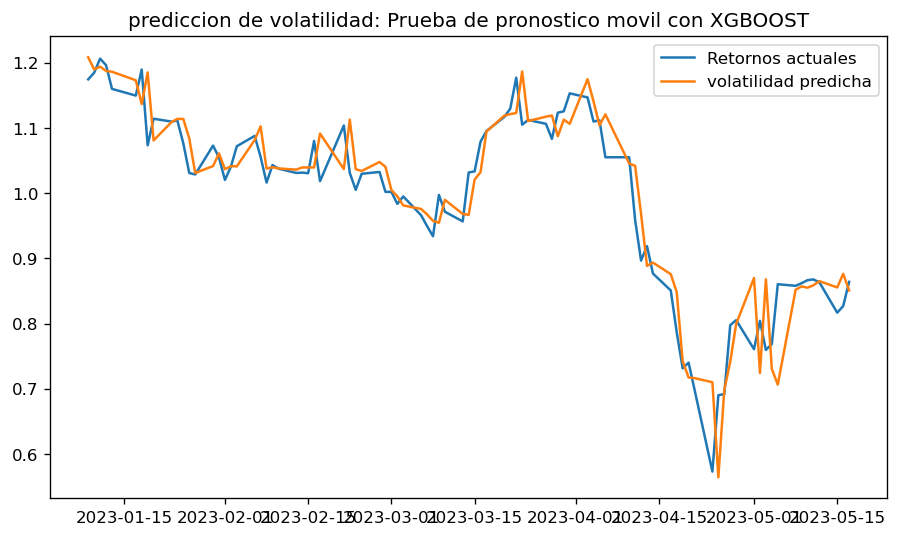

In [82]:
true, = plt.plot(test_ml['win_22'])
preds, = plt.plot(test_ml['Predictions'])
plt.title('prediccion de volatilidad: Prueba de pronostico movil con XGBOOST')
plt.legend(['Retornos actuales','volatilidad predicha'])

# Evaluacion

RMSE
MAPE


In [83]:
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.787872,0.668991
2021-01-27,0.814518,0.977675
2021-01-28,0.933830,0.998550
2021-01-29,1.196368,1.042418
2021-02-01,1.085360,1.125609
...,...,...
2023-05-11,0.878676,0.977655
2023-05-12,0.913728,0.978227
2023-05-15,0.911648,0.981210


In [84]:
RMSE_serie = mean_squared_error(garch_and_rolling_std['close'],garch_and_rolling_std['cond_vol'],squared=False)
MAPE_serie = mean_absolute_percentage_error(garch_and_rolling_std['close'],garch_and_rolling_std['cond_vol'])
print(f"el RMSE del modelo GARCH en los datps de la serie completa es: {round(RMSE_serie,4)}")
print(f"el MAPE del modelo GARCH en los datps de la serie completa es: {round(MAPE_serie*100,4)}%")

el RMSE del modelo GARCH en los datps de la serie completa es: 0.168
el MAPE del modelo GARCH en los datps de la serie completa es: 15.3468%


In [88]:
true_vol = rolling_vol[-test_size:]
pred_vol = rolling_predictions
RMSE = mean_squared_error(true_vol,pred_vol,squared=False)
MAPE = mean_absolute_percentage_error(true_vol,pred_vol)
print(f"el RMSE del modelo GARCH en los datos predichos es: {round(RMSE,4)}")
print(f"el MAPE del modelo GARCH en los datos predichos es: {round(MAPE*100,4)}%")

el RMSE del modelo GARCH en los datos predichos es: 0.1208
el MAPE del modelo GARCH en los datos predichos es: 11.6928%


In [89]:
RMSE_Serie_XG = mean_squared_error(train_ml['win_22'],train_ml['Predictions'],squared=False)
MAPE_serie_XG = mean_absolute_percentage_error(train_ml['win_22'],train_ml['Predictions'])
print(f"el RMSE del modelo XGBOOST en los datos de la serie completa es: {round(RMSE_Serie_XG,4)}")
print(f"el MAPE del modelo XGBOOST en los datos de la serie completa es: {round(MAPE_serie_XG*100,4)}%")

el RMSE del modelo XGBOOST en los datos de la serie completa es: 0.0341
el MAPE del modelo XGBOOST en los datos de la serie completa es: 2.3083%


In [90]:
true_vol = test_ml['Predictions']
pred_vol = test_ml['win_22']
RMSE_XG=mean_squared_error(true_vol,pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol,pred_vol)
print(f"el RMSE del modelo XGBOOST en los datos pevistos es: {round(RMSE_XG,4)}")
print(f"el MAPE del modelo XGBOOST en los datos pedichos es: {round(MAPE_XG*100,4)}%")

el RMSE del modelo XGBOOST en los datos pevistos es: 0.0467
el MAPE del modelo XGBOOST en los datos pedichos es: 3.5515%
